# Investigating Factors Affecting Housing Rental Yields (Using ONS Data)

## Purpose

The aim of this notebook is to use various public ONS (`https://www.ons.gov.uk/`) datasets to find factors affecting housing yields. I hope this will give readers (and potential investors) a better idea of what drives rental yields, hopefully allowing for better decision making.

Note: Here I look at yields instead of raw house prices since yields are comparable across different locations.

I approximate average yields using `median(rental income)/median(house price)` since the actual average yield, `median(rental income / house price)`, requires data for each house and is otherwise unavailable.


## Data Used

Below I list the ONS datasets I will be using. The full urls are given at the end.

- Crime
- Private Rental Statistics
- Median House Price
- Mean House Price
- Property Sales
- Population Estimates
- Quality of Life Estimates

These are the datasets I found on the ONS website I thought will be relevant and suitable to work with.

These give data reported by local authority so we will have a reasonable number of data points (roughly 300) to perform inference on.

In [49]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from ons_processing import parse_files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data
We call all `parse_*` functions in `parse_files.py` to load all collected datasets and join on `la_code`.

In [92]:
csv_dir = "./ons_processing/data"
datasets = ["property_sales", "crime", "rental_summary", "population_age", "wellbeing", "property_prices"]
data = {k: getattr(parse_files, f"parse_{k}")(csv_dir) for k in datasets}
print({k: df.shape for k, df in data.items()})

{'property_sales': (336, 2), 'crime': (311, 4), 'rental_summary': (357, 4), 'population_age': (331, 6), 'wellbeing': (421, 5), 'property_prices': (331, 2)}


/home/nikul/Documents/Programming/ons_housing/ons_processing/parse_files.py:21: DtypeWarning: Columns (0,1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path, **read_kwargs)


## Data Cleaning
We lose some data in the joining process because not all datasets have data for all local authorities. Imputing these values would introduce too much noise (we go from roughly 330 areas per dataset before joining to roughly 270 after joining) since the % of lost data points is large.


We also have some missing data after joining. Let's investigate whether it will be sensible to impute these values or to drop them.

In [152]:
from functools import reduce
joined = reduce(lambda x, y: x.merge(y, on="la_code"), data.values()) # merge all dataframes on la code
print(joined.shape)

(267, 18)


### Missing Values
We can see num_households, total_crime, burgalry_per_household are not inferred as numeric types. Looking at the raw data we can see this is because there are missing values marked as `[x]`.

In [153]:
joined.dtypes

la_code                    object
num_sold                  float64
num_households             object
total_crime                object
burgalry_per_household     object
rent_count                  int64
median_rent                 int64
mean_rent                   int64
la_name                    object
total_population            int64
child                       int64
adult                       int64
elderly                     int64
anxiety                   float64
happiness                 float64
life-satisfaction         float64
worthwhile                float64
property_price              int64
dtype: object

In [157]:
to_convert = ["num_households", "total_crime", "burgalry_per_household"]

for col in to_convert:
    joined.loc[:, col] = pd.to_numeric(joined[col], errors="coerce")

### Imputing Data
There are only a few data points with missing values. Their distributions look relatively simple, so let's impute them by replacing the missing values with their respective medians to avoid data loss (at the expense of possibly introducing biases/noise to the data).

In [165]:
num_missing = joined.isna().sum()
num_missing = num_missing[num_missing!=0]
print(num_missing)

total_crime               11
burgalry_per_household    11
anxiety                    5
happiness                  3
life-satisfaction          3
worthwhile                 3
dtype: int64


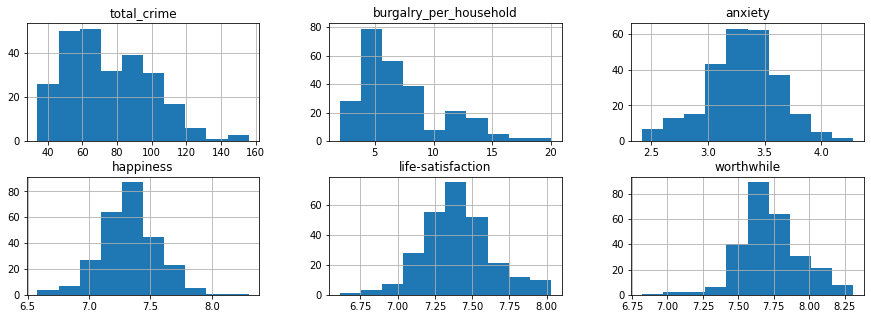

In [176]:
import matplotlib.pyplot as plt
_ = joined[num_missing.index].hist(figsize=(15, 5), layout=(2, 3))
plt.show()

In [182]:
joined = joined.fillna(joined[num_missing.index].median()) # replace missing values with their medians

In [186]:
print(joined.shape) # we lose 5 data points
joined.to_parquet("./ons_processing/data/joined.pq") # save for convenience

(267, 18)


## Exploratory Data Analysis
Now that we've prepared the raw data we'll be using, let's explore it.

In [187]:
joined = pd.read_parquet("./ons_processing/data/joined.pq") # load previously saved results

### Distribution Plots
Let's look at how the individual features are distributed. Some observations:

- Data directly to do with property + population (num_sold, median_rent, total_population, ...) tend to be highly positively skewed
  - This is likely from a few outlier regions with large populations (eg areas in London)
- The life satisfaction measures (happiness, ...) have almost no skew, but I would have expected skew for the same reason why the other fields are skewed
  - These measures are highly subjective however, so could impact their effectiveness as a predictor

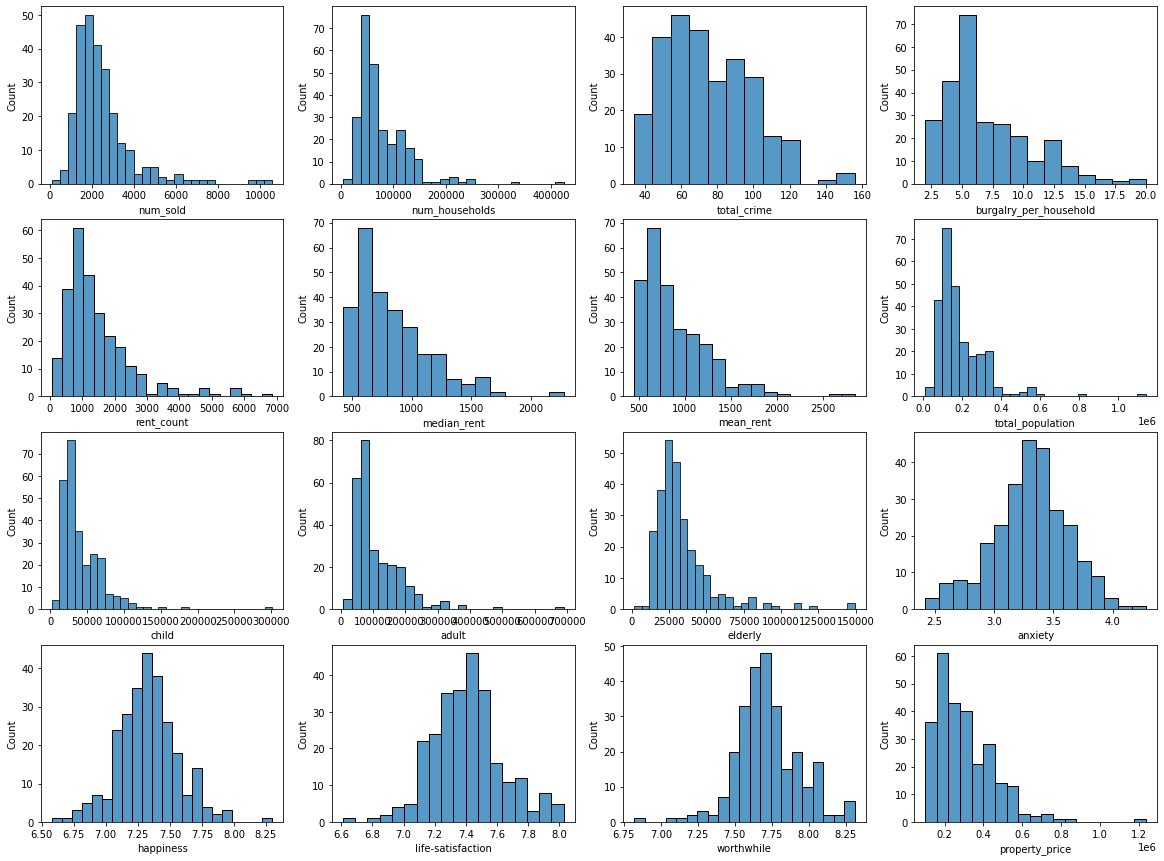

In [189]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(20, 15))
to_exclude = ["la_code", "la_name"]
to_boxplot = [k for k in joined.columns if k not in to_exclude]

for col, ax_ in zip(to_boxplot, ax.ravel()):
    sns.histplot(joined[col], ax=ax_)

### Data Sanity Check
Let's do a quick sanity check on the data by looking at the areas with the highest house prices. These are all in Central London which matches with expectations.

In [197]:
i = joined.property_price.sort_values().tail(5).index
print(joined.iloc[i][["la_name", "property_price"]])

                    la_name  property_price
234          City of London          720000
246  Hammersmith and Fulham          750000
240                  Camden          777000
266             Westminster          865000
253  Kensington and Chelsea         1237500


### Pairwise Distribution Plots
Let's now look at some pairwise plots between the data columns. I've chosen a subset of columns to plot for clarity. Some observations:

- We see some expected relationships, eg property price:
  - increases (almost linearly) with median rent
  - generally increases with increased population
  - generally decreases with increased crime
- Happiness doesn't seem to be related to anything
  - This is consistent with the prior observation that since it is subjective, it may lack predictive ability

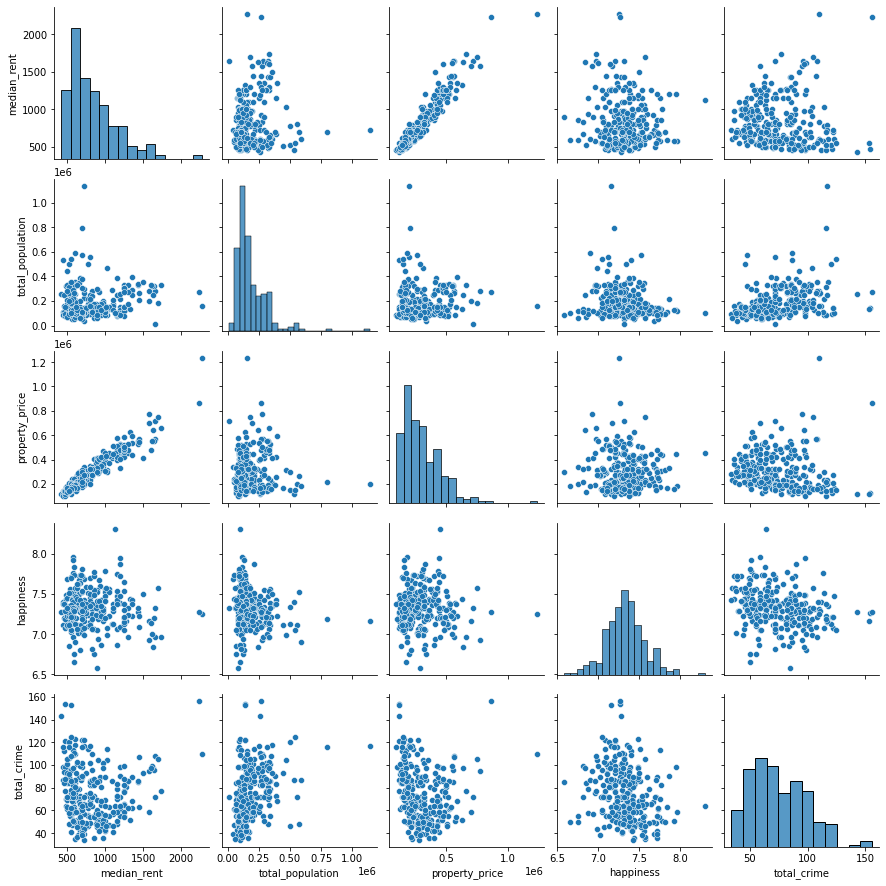

In [205]:
import seaborn as sns

pairplot_subset = ["median_rent", "total_population", "property_price", "happiness", "total_crime"]
sns.pairplot(joined[pairplot_subset])
plt.show()

## Feature Engineering
Now we've had an initial look at the data, let's create some features that can be compared across regions so we can better analyse the data.

Specifically, we will create unitless quantities (eg crime per capita instead of total crime) that can be compared across local areas.

### Location Data
We can use `geopy` to query for the latitude and longitude and the full names of each data point using the local authority name. These will be useful for plotting on a map and as features.

In [243]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="myApp")

def query_location(la_name):
    """Use geopy to find the full location string and (latitude, longitude)
    coordinates of the given local authority name
    """
    location = geolocator.geocode(f"{la_name}, UK")
    if location:
        return location
    return (np.nan, (np.nan, np.nan)) # failed to find location

In [247]:
location = joined.la_name.apply(query_location)
location = location.apply(lambda x: pd.Series([x[0], *x[1]], index=["location_string", "latitude", "longitude"]))

#### Location Error
There was one area where this failed to find the location data. Looking at the name `Kingston upon Hull, City of...` it is clear why this failed (the name is too long/unconventional). For simplicity we'll drop this data point.

In [255]:
joined[joined.isna().any(axis=1)]

,la_code,num_sold,num_households,total_crime,burgalry_per_household,rent_count,median_rent,mean_rent,la_name,total_population,...,adult,elderly,anxiety,happiness,life-satisfaction,worthwhile,property_price,location_string,latitude,longitude
9,E06000010,2727.0,113500,143.0,15.0,2460,425,447,"Kingston upon Hull, City of",259126,...,159283,39437,3.16,7.28,7.14,7.44,120000,NaN,NaN,NaN


In [ ]:
joined = pd.concat([joined, location], axis=1).dropna() # join to original dataframe and drop 1 row missing location information

### Other Features
Let's continue our feature engineering. Below I construct some features and briefly justify each one.

In [269]:
joined.loc[:, "rental_yield"] = 12 * joined["median_rent"] / joined["property_price"] # our target as described at the start, an approximation to the average rental yield
joined.loc[:, "crime_per_capita"] = joined["total_crime"] / joined["total_population"] # crime rate per person is comparable across regions with differing populations

for k in ["child", "adult", "elderly"]: # proportion of population in each age group is comparable
    joined.loc[:, f"{k}_prop"] = joined[k] / joined["total_population"]
    
joined.loc[:, "prop_renting"] = joined["rent_count"] / joined["num_households"] # The proportion of households renting; if this is high it would indicate a more crowded rental market
joined.loc[:, "avg_household_size"] = joined["total_population"] / joined["num_households"] # Smaller family size could indicate a higher likelihood of renting

## Feature Inspection
Let's visualise the pairwise interactions of rental yield with the other features. We see some interesting patterns:

- Rental yield increases with crime rate
  - This is consistent with intuition: houses with higher rents are more worthwile to break into
- Yield is negatively correlated with the proportion of elderly population and positively correlated with the child and adult populations
  - A possible explanation is that elderly people are more likely to be homeowners and live in areas with low rental demand
  - Conversely, young adults and families with children are more likely to rent which would increase rental demand
  - These are possibly supported by the slight positive correlation between the proportion of households renting and yield (but the connection here is very slight)
- Happiness is negatively correlated with yield
  - This is difficult to interpret since happiness is subjective; could people be less happy to live in expensive, high rent areas?
- Yields tend to be higher in the North (latitude) and higher in the West (longitude)
  - The lower yields in the South and the East (ie London and surrounding areas) could reflect the premium paid for houses in these areas

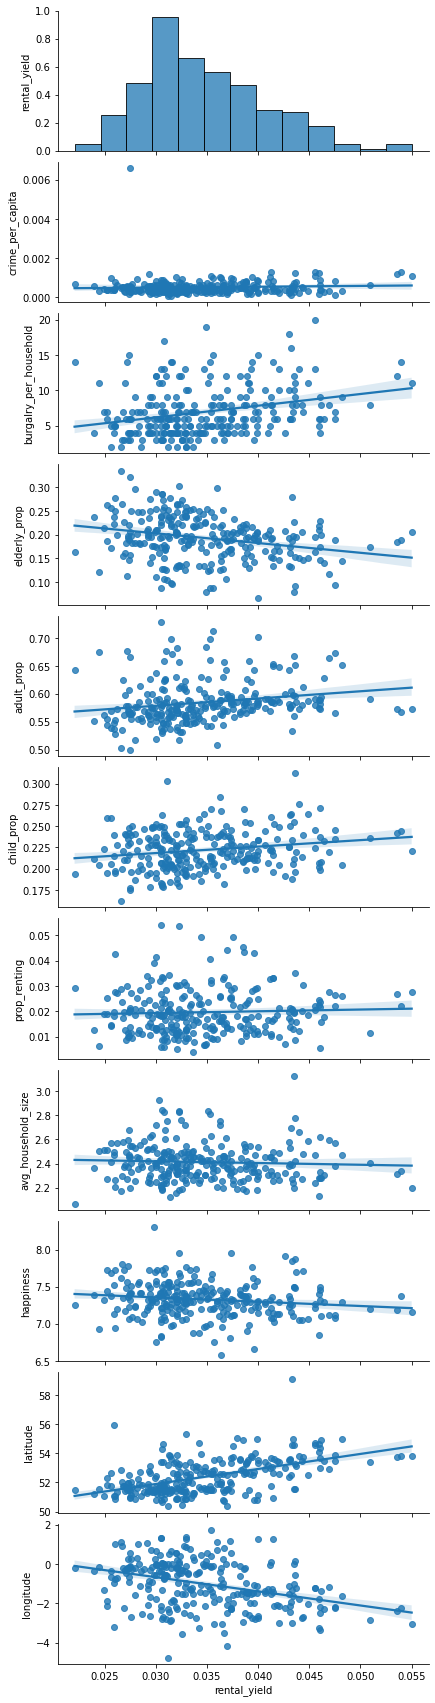

In [285]:
features = ["rental_yield", "crime_per_capita", "burgalry_per_household", "elderly_prop", "adult_prop", "child_prop", "prop_renting", "avg_household_size", "happiness", "latitude", "longitude"]
g = sns.pairplot(joined[features], x_vars=["rental_yield"], kind="reg")
g.fig.set_size_inches(8,24)
plt.show()

## Model Fitting/Feature Selection

Now we've inspected the data, created and briefly looked at a few engineered features let's get a more quantitative measure of the usefulness of this data.

I explore answers to:
- What are the most important features influencing rental yields?
- Can we model rental yields well using the data we have?

### Model Fitting

We only have roughly 270 data points to work with, so I will use a linear model since it will reduce the chances of overfitting.

To understand how well a linear model can fit the data I will calculate an out of sample `R2` coefficient over k test sets in a k-fold cross validation. This will give a distribution of `R2` scores so we can be more confident about the conclusions we draw compared to if we had a single point.

Note: we choose `R2` as the metric since we want to assess whether we can accurately model rental yields using our data, with a perfect score being 1

count    200.000000
mean       0.179504
std        0.757042
min       -5.036810
25%        0.119093
50%        0.424659
75%        0.543822
max        0.837623
dtype: float64


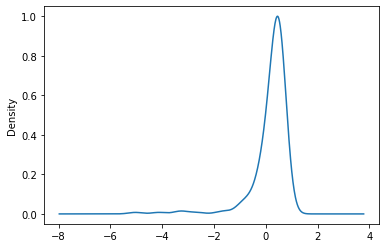

In [373]:
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold

folds = list(RepeatedKFold(n_splits=20, n_repeats=10, random_state=42).split(joined))
features = ["crime_per_capita", "burgalry_per_household", "elderly_prop", "adult_prop", "child_prop", "prop_renting", "avg_household_size", "happiness", "latitude", "longitude"]
target = "rental_yield"
joined_to_xy = lambda df: (df[features], df[target]) # Separate the target from the features


def score_on_folds(model, folds):
    scores = []
    for train_ind, test_ind in folds:
        train = joined_to_xy(joined.iloc[train_ind])
        test = joined_to_xy(joined.iloc[test_ind])
        
        model_ = clone(model).fit(*train)
        scores.append(model_.score(*test))
        
    return scores
        
scores = pd.Series(score_on_folds(LinearRegression(), folds))
scores.plot.density()
print(scores.describe())
plt.show()

### Initial Results
The median score is 0.42 (note: there is a long left tail since `R2` takes values in (-inf, 1]), however I suspect we're underfitting since the model is very simple.

We can check this by reducing the complexity of our model by applying regularisation (using a Ridge model) and seeing the performance worsen overall. We see the score monotonically decrease with the regularisation, so we are underfitting

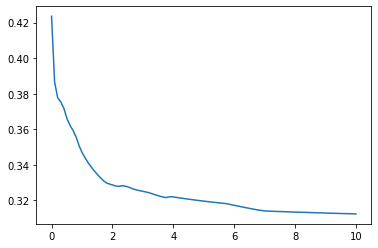

In [381]:
from sklearn.linear_model import Ridge

alphas = np.linspace(0, 10, 100)
alpha_scores = {}

for alpha in alphas:
    scores = pd.Series(score_on_folds(Ridge(alpha=alpha), folds))
    alpha_scores[alpha] = scores.median()

pd.Series(alpha_scores).plot()
plt.show()

### Model Iteration
Let's try a more complex model - a Support Vector Regressor. This will allow us to capture more complex patterns in the data (note: I changed the default hyperparameters to be more suitable for our problem via trial and error - we should also check the results are not too sensitive to this, but I'll omit this for simplicity).

We see a small improvement in the median score `42% -> 48%`! This confirms that we were underfitting earlier. Moreover, the minimum + lower quartile score is much higher than the previous minimum + lower quartile, so this model is also more consistent than the previous one.

count    200.000000
mean       0.412325
std        0.307304
min       -1.197223
25%        0.289648
50%        0.476421
75%        0.629408
max        0.896204
dtype: float64


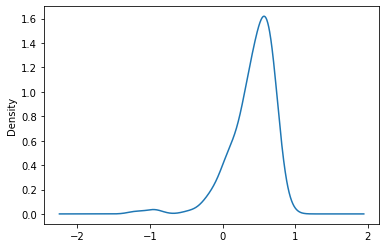

In [399]:
from sklearn.svm import SVR

scores = pd.Series(score_on_folds(SVR(C=100, epsilon=1e-5), folds))
print(scores.describe())
scores.plot.density()
plt.show()

### Putting Things into Context
Now we've established an expected `R2` score of roughly 50% for this problem, let's consider what this means in the context of our problem of modelling housing yields.

An `R2` score of 50% on a dataset of this size is probably statistically significant and considered to be good for (somewhat) noisy regression problems like this one. I imagine there are many other factors affecting housing yields that we haven't considered/have data for. Including these would improve performance, but for this current set of results I would say the conclusion is that we are able to model housing yields reasonably well (ie we can use these models to make decent predictions) using the data we have collected.

## Feature Selection/Importance
We also care about predictors that can best model our target variable. Since we have a small number of data points and for simplicity I will do this using a Lasso model. The L1 penalty will shrink coefficients to 0 (for a large enough regularisation) so this will act as our "feature selection" to see what's most important. Moreover we can look at the magnitude of the regression coefficients to determine the relative importance of the features.

The selected (last few non-zero) features are `elderly_prop, latitude, longitude, burgalry_per_household, ...`. There are clearly confounding variables here (eg `latitude` itself shouldn't drive rental yields), however since the model is incomplete (we don't have all the relevant variables driving rental yields) this might be expected - the selected variables could be proxies for the actual relevant underlying variables.

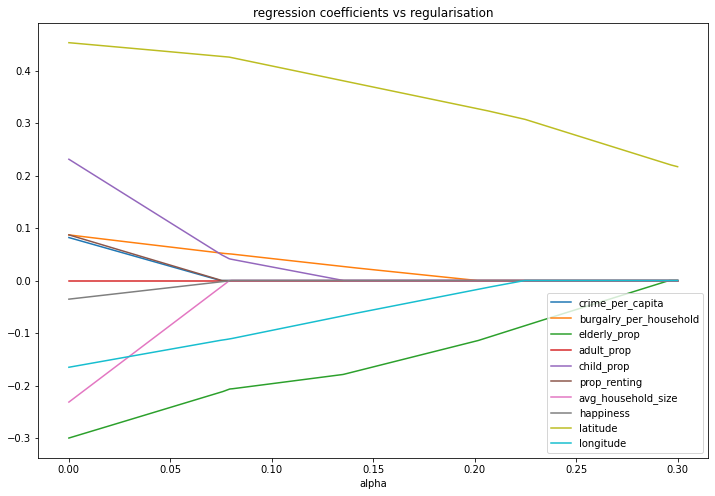

In [470]:
from sklearn.linear_model import Lasso

joined_standardised = (joined-joined.mean()) / joined.std() # need to standardise before fitting with regulatisation
alphas = np.linspace(1e-5, 0.3, 1000)

lasso_coef = lambda alpha: Lasso(alpha=alpha, max_iter=10000).fit(*joined_to_xy(joined_standardised)).coef_

coef_dict = {alpha: dict(zip(features, lasso_coef(alpha))) for alpha in alphas}
coef_df = pd.DataFrame(coef_dict)
coef_df.T.plot(figsize=(12, 8), title="regression coefficients vs regularisation", xlabel="alpha")
plt.show()

#### Examining the Coefficients
We see a similar picture here as for the bivariate plots of features vs rental yield above, although now we have an tangible measure of how each variable in isolation affects rental yields.

In [471]:
coef_df.iloc[:, 0].sort_values(key=lambda x: abs(x), ascending=False)

latitude                  0.453086
elderly_prop             -0.300001
avg_household_size       -0.231512
child_prop                0.231058
longitude                -0.165187
prop_renting              0.087028
burgalry_per_household    0.086966
crime_per_capita          0.081893
happiness                -0.035463
adult_prop                0.000000
Name: 1e-05, dtype: float64

## Data Sources

Crime
- https://www.ons.gov.uk/peoplepopulationandcommunity/crimeandjustice/datasets/recordedcrimedatabycommunitysafetypartnershiparea

Private Rental Statistics
- https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/privaterentalmarketsummarystatisticsinengland

Median House Price
- https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbywardhpssadataset37

Mean House Price
- https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/meanpricepaidbywardhpssadataset38

Property Sales
- https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/numberofresidentialpropertysalesbywardhpssadataset36

Population Estimates
- https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental

Quality of Life Estimates
- https://www.ons.gov.uk/datasets/wellbeing-local-authority/editions/time-series/versions/2

Note: the ONS has an API (https://developer.ons.gov.uk/) however these not all of these datasets are not available through this at the time of writing. Also, due issues parsing these excel files, I have manually exported the data to csvs which can be straightforwardly parsed.